# はじめに

ESRGANの超解像を試してみよう。

## import

In [1]:
import os
import os.path as osp
from glob import glob

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision.models import vgg19
import torchvision.transforms as transforms
import sys
import json
import random

from torch import optim
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import save_image

## パスの定義

In [2]:
#ルートディレクトリ content/esrgan/
ROOT = 'esrgan/'

# Colab内に保存 content/esrgan/output
output_dir = osp.join(ROOT, 'output')

# 入力となるデータセットを保存するディレクトリ content/esrgan/input
input_dir = osp.join(ROOT, 'input')
os.makedirs(input_dir, exist_ok=True)

In [3]:
# 画像を保存するディレクトリ content/esrgan/input/images
image_dir = osp.join(input_dir, 'images')

# アノテーションデータを保存するディレクトリ content/esrgan/input/annotations
annotations_dir = osp.join(input_dir, 'annotations')

# アノテーションのリストファイルのパス content/esrgan/input/annotations/list.txt
list_path = osp.join(annotations_dir, 'list.txt')

In [4]:
# データセットのディレクトリ content/esrgan/input/cat_face
dataset_dir = osp.join(input_dir, 'cfd_sim')

# データセットの学習データを保存するディレクトリ content/esrgan/input/cat_face/train
train_dir = osp.join(dataset_dir, 'train')

# データセットのテストデータを保存するディレクトリ content/esrgan/input/cat_face/test
test_dir = osp.join(dataset_dir, 'test')

# デモ用のデータを保存するディレクトリ content/esrgan/input/cat_face/demo
demo_dir = osp.join(dataset_dir, 'demo')
print(dataset_dir)

esrgan/input/cfd_sim


In [5]:
image_train_save_dir = osp.join(output_dir, 'image', 'train')
image_test_save_dir = osp.join(output_dir, 'image', 'test')
weight_save_dir = osp.join(output_dir, 'weight')
param_save_path = osp.join(output_dir, 'param.json')

save_dirs = [image_train_save_dir, image_test_save_dir, weight_save_dir]
for save_dir in save_dirs:
    print(save_dir)
    os.makedirs(save_dir, exist_ok=True)

log_dir = './logs'
os.makedirs(log_dir, exist_ok=True)

esrgan/output/image/train
esrgan/output/image/test
esrgan/output/weight


In [6]:
#訓練データのディレクトリ content/esrgan/input/cat_face/train
train_data_dir = osp.join(dataset_dir, 'train')

#検証データのディレクトリ content/esrgan/input/cat_face/test
test_data_dir = osp.join(dataset_dir, 'test')

#テストデータのディレクトリ content/esrgan/input/cat_face/demo
demo_data_dir = osp.join(dataset_dir, 'demo')

## シード固定

In [7]:
seed = 19930124

random.seed(seed)  
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

dataset_name = 'cat_face'

## 関数

In [8]:
def mse(y, t):
    return 0.5 * np.sum((y - t) **2)

## 学習用のデータセット読み込みクラス

In [9]:
class ImageDataset(Dataset):
    def __init__(self, dataset_dir, hr_shape):
        dataset_lrdir =osp.join(dataset_dir, "bin_32")
        dataset_hrdir =osp.join(dataset_dir, "bin_128")
        
        self.lr_files = sorted(glob(osp.join(dataset_lrdir, "*")))
        self.hr_files = sorted(glob(osp.join(dataset_hrdir, "*")))

    def __getitem__(self, index):
        img_lr = torch.from_numpy((np.load(self.lr_files[index % len(self.lr_files)])).astype(np.float32)).clone()
        img_hr = torch.from_numpy((np.load(self.hr_files[index % len(self.hr_files)])).astype(np.float32)).clone()
        
        return {"lr": img_lr, "hr": img_hr}

    def __len__(self):
        return len(self.lr_files)

## 学習中の画像確認とデモ用のデータセット読込クラス

In [10]:
class TestImageDataset(Dataset):
    """
    Generatorによる途中経過の確認のためのDatasetクラス
    lr_transformで入力画像を高さと幅それぞれ1/4の低解像度の画像を生成し、
    hr_transformでオリジナルの画像を高解像度の画像として用いる
    """
    def __init__(self, dataset_dir):
        dataset_lrdir =osp.join(dataset_dir, "bin_32")
        dataset_hrdir =osp.join(dataset_dir, "bin_128")
        
        self.lr_files = sorted(glob(osp.join(dataset_lrdir, "*")))
        self.hr_files = sorted(glob(osp.join(dataset_hrdir, "*")))

    def __getitem__(self, index):
        img_lr = torch.from_numpy((np.load(self.lr_files[index % len(self.lr_files)])).astype(np.float32)).clone()
        img_hr = torch.from_numpy((np.load(self.hr_files[index % len(self.hr_files)])).astype(np.float32)).clone()
        
        return {"lr": img_lr, "hr": img_hr}

    def __len__(self):
        return len(self.lr_files)

# ESRGAN

## 生成器のResidual Block

In [11]:
class DenseResidualBlock(nn.Module):
    """
    GenearatorのDenseResidualBlockのクラス
    """
    def __init__(self, filters, res_scale=0.2):
        super(DenseResidualBlock, self).__init__()
        self.res_scale = res_scale
        
        def block(in_features, non_linearity=True):
            layers = [nn.Conv2d(in_features, filters, 3, 1, 1, bias=True)]
            if non_linearity:
                layers += [nn.LeakyReLU()]
            return nn.Sequential(*layers)
    
        self.b1 = block(in_features=1 * filters)
        self.b2 = block(in_features=2 * filters)
        self.b3 = block(in_features=3 * filters)
        self.b4 = block(in_features=4 * filters)
        self.b5 = block(in_features=5 * filters, non_linearity=False)
        self.blocks = [self.b1, self.b2, self.b3, self.b4, self.b5]
    
    def forward(self, x):
        inputs = x
        for block in self.blocks:
            out = block(inputs)
            inputs = torch.cat([inputs, out], 1)
        return out.mul(self.res_scale) + x

## 生成器のResidual in Residual Block

In [12]:
class ResidualInResidualDenseBlock(nn.Module):
    """
    GenearatorのResidualInResidualDenseBlockのクラス
    """
    def __init__(self, filters, res_scale=0.2):
        super(ResidualInResidualDenseBlock, self).__init__()
        self.res_scale = res_scale
        self.dense_blocks = nn.Sequential(
            DenseResidualBlock(filters), 
            DenseResidualBlock(filters), 
            DenseResidualBlock(filters)
        )
    
    def forward(self, x):
        return self.dense_blocks(x).mul(self.res_scale) + x

## 生成器

In [13]:
class GeneratorRRDB(nn.Module):
    """
    Generatorのクラス
    """
    def __init__(self, channels, filters=64, num_res_blocks=16, num_upsample=2):
        super(GeneratorRRDB, self).__init__()
        
        self.conv1 = nn.Conv2d(channels, filters, kernel_size=3, stride=1, padding=1)
        
        self.res_blocks = nn.Sequential(*[ResidualInResidualDenseBlock(filters) 
                                        for _ in range(num_res_blocks)])
        self.conv2 = nn.Conv2d(filters, filters, kernel_size=3, stride=1, padding=1)
        
        upsample_layers = []
        
        for _ in range(num_upsample):
            upsample_layers += [
                nn.Conv2d(filters, filters * 4, kernel_size=3, stride=1, padding=1),
                nn.LeakyReLU(),
                nn.PixelShuffle(upscale_factor=2),
            ]
        self.upsampling = nn.Sequential(*upsample_layers)
        self.conv3 = nn.Sequential(
            nn.Conv2d(filters, filters, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(filters, channels, kernel_size=3, stride=1, padding=1),
        )
    
    def forward(self, x):
        out1 = self.conv1(x)
        out = self.res_blocks(out1)
        out2 = self.conv2(out)
        out = torch.add(out1, out2)
        out = self.upsampling(out)
        out = self.conv3(out)
        return out

## 生成器の特徴量抽出器

In [14]:
class FeatureExtractor(nn.Module):
    """
    Perceputual lossを計算するために特徴量を抽出するためのクラス
    """
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        vgg19_model = vgg19(pretrained=True)
        self.vgg19_54 = nn.Sequential(*list(
            vgg19_model.features.children())[:35])

    def forward(self, img):
        return self.vgg19_54(img)

## 識別機

In [15]:
class Discriminator(nn.Module):
    """
    Discriminatorのクラス
    """
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()
                
        self.input_shape = input_shape
        in_channels, in_height, in_width = self.input_shape
        patch_h, patch_w = int(in_height / 2 ** 4), int(in_width / 2 ** 4)
        self.output_shape = (1, patch_h, patch_w)
    
        def discriminator_block(in_filters, out_filters, first_block=False):
            layers = []
            layers.append(nn.Conv2d(in_filters, 
                                    out_filters, 
                                    kernel_size=3, 
                                    stride=1, 
                                    padding=1))
            if not first_block:
                layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            layers.append(nn.Conv2d(out_filters, 
                                    out_filters, 
                                    kernel_size=3, 
                                    stride=2, 
                                    padding=1))
            layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        
        layers = []
        in_filters = in_channels
        for i, out_filters in enumerate([64, 128, 256, 512]):
            print(discriminator_block(in_filters, 
                                      out_filters, 
                                      first_block=(i == 0)))
            layers.extend(discriminator_block(in_filters, 
                                              out_filters, 
                                              first_block=(i == 0)))
            in_filters = out_filters
        
        layers.append(nn.Conv2d(out_filters, 
                                1, 
                                kernel_size=3, 
                                stride=1, 
                                padding=1))
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, img):
        return self.model(img)

## ESRGAN

In [16]:
class ESRGAN():
    """
    ESRGANの処理を実装するクラス
    """
    def __init__(self, opt):
        self.generator = GeneratorRRDB(opt.channels, filters=64, num_res_blocks=opt.residual_blocks).to(opt.device)
        self.discriminator = Discriminator(input_shape=(opt.channels, *hr_shape)).to(opt.device)

        self.feature_extractor = FeatureExtractor().to(opt.device)
        self.feature_extractor.eval()

        self.criterion_GAN = nn.BCEWithLogitsLoss().to(opt.device)
        self.criterion_content = nn.L1Loss().to(opt.device)
        self.criterion_pixel = nn.L1Loss().to(opt.device)

        self.optimizer_G = optim.Adam(self.generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
        self.optimizer_D = optim.Adam(self.discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

        self.Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.Tensor
        self.writer = SummaryWriter(log_dir=log_dir)
    
    def pre_train(self, imgs, batches_done, batch_num):
        """
        loss pixelのみで事前学習を行う
        """
        with torch.no_grad():
            # preprocess
            imgs_lr = Variable(imgs['lr'].type(self.Tensor))
            imgs_hr = Variable(imgs['hr'].type(self.Tensor))

            # ground truth
            valid = Variable(self.Tensor(np.ones((imgs_lr.size(0), *self.discriminator.output_shape))), 
                              requires_grad=False)
            fake = Variable(self.Tensor(np.zeros((imgs_lr.size(0), *self.discriminator.output_shape))), 
                            requires_grad=False)

        # バックプロパゲーションの前に勾配を0にする
        self.optimizer_G.zero_grad()


        # 低解像度の画像から高解像度の画像を生成
        gen_hr = self.generator(imgs_lr)

        loss_pixel = self.criterion_pixel(gen_hr, imgs_hr)

        # 画素単位の損失であるloss_pixelで事前学習を行う
        loss_pixel.backward()
        self.optimizer_G.step()
        train_info = {'epoch': epoch, 'batch_num': batch_num, 'loss_pixel': loss_pixel.item()}
        if batch_num == 1:
            sys.stdout.write('\n{}'.format(train_info))
        else:
            sys.stdout.write('\r{}'.format('\t'*20))
            sys.stdout.write('\r{}'.format(train_info))
        sys.stdout.flush()

        self.save_loss(train_info, batches_done)

    def train(self, imgs, batches_done, batch_num):
        """
        pixel loss以外の損失も含めて本学習を行う
        """
        with torch.no_grad():
            # 前処理
            imgs_lr = Variable(imgs['lr'].type(self.Tensor))
            imgs_hr = Variable(imgs['hr'].type(self.Tensor))

            # 正解ラベル
            valid = Variable(self.Tensor(np.ones((imgs_lr.size(0), *self.discriminator.output_shape))), 
                              requires_grad=False)
            fake = Variable(self.Tensor(np.zeros((imgs_lr.size(0), *self.discriminator.output_shape))), 
                            requires_grad=False)

        # 低解像度の画像から高解像度の画像を生成
        self.optimizer_G.zero_grad()
        gen_hr = self.generator(imgs_lr)

        # Pixel loss
        loss_pixel = self.criterion_pixel(gen_hr, imgs_hr)

        # 推論
        pred_real = self.discriminator(imgs_hr).detach()
        pred_fake = self.discriminator(gen_hr)

        # Adversarial loss
        loss_GAN = self.criterion_GAN(pred_fake - pred_real.mean(0, keepdim=True), valid)

        # Perceptual loss
        gen_feature = self.feature_extractor(gen_hr)
        real_feature = self.feature_extractor(imgs_hr).detach()
        loss_content = self.criterion_content(gen_feature, real_feature)

        # 生成器のloss
        loss_G = loss_content + opt.lambda_adv * loss_GAN + opt.lambda_pixel * loss_pixel
        loss_G.backward()
        self.optimizer_G.step()

        # 識別機のLoss
        self.optimizer_D.zero_grad()
        pred_real = self.discriminator(imgs_hr)
        pred_fake = self.discriminator(gen_hr.detach())

        loss_real = self.criterion_GAN(pred_real - pred_fake.mean(0, keepdim=True), valid)            
        loss_fake = self.criterion_GAN(pred_fake - pred_real.mean(0, keepdim=True), fake)    
        loss_D = (loss_real + loss_fake) / 2
        loss_D.backward()
        self.optimizer_D.step()

        train_info = {'epoch': epoch, 'batch_num': batch_num,  'loss_D': loss_D.item(), 'loss_G': loss_G.item(),
                      'loss_content': loss_content.item(), 'loss_GAN': loss_GAN.item(), 'loss_pixel': loss_pixel.item(),}
        if batch_num == 1:
            sys.stdout.write('\n{}'.format(train_info))
        else:
            sys.stdout.write('\r{}'.format('\t'*20))
            sys.stdout.write('\r{}'.format(train_info))
        sys.stdout.flush()

        self.save_loss(train_info, batches_done)

    def save_loss(self, train_info, batches_done):
        """
        lossの保存
        """
        for k, v in train_info.items():
            self.writer.add_scalar(k, v, batches_done)

    def save_image(self, imgs, batches_done):
        """
        画像の保存
        """
        with torch.no_grad():
            # Save image grid with upsampled inputs and outputs
            imgs_lr = Variable(imgs["lr"].type(self.Tensor))
            gen_hr = self.generator(imgs_lr)
            self.writer.add_image('image_{}'.format(i), gen_hr[0], batches_done)

            image_batch_save_dir = osp.join(image_test_save_dir, '{:03}'.format(i))
            # gen_hr_dir = osp.join(image_batch_save_dir, "hr_image")
            os.makedirs(image_batch_save_dir, exist_ok=True)
            save_image(gen_hr, osp.join(image_batch_save_dir, "{:09}.png".format(batches_done)), nrow=1, normalize=False)

    def save_weight(self, batches_done):
        """
        重みの保存
        """
        # Save model checkpoints
        generator_weight_path = osp.join(weight_save_dir, "generator_{:08}.pth".format(batches_done))
        discriminator_weight_path = osp.join(weight_save_dir, "discriminator_{:08}.pth".format(batches_done))

        torch.save(self.generator.state_dict(), generator_weight_path)
        torch.save(self.discriminator.state_dict(), discriminator_weight_path)

In [17]:
def save_json(file, save_path, mode):
    """Jsonファイルを保存
    """
    with open(save_path, mode) as outfile:
        json.dump(file, outfile, indent=4)

## パラメータ

In [18]:
class Opts():
    def __init__(self):
        self.n_epoch = 50
        self.residual_blocks = 23
        self.lr = 0.0002
        self.b1 = 0.9
        self.b2 = 0.999
        self.batch_size = 8
        self.n_cpu = 8
        self.warmup_batches = 500
        self.lambda_adv = 5e-3
        self.lambda_pixel = 1e-2
        self.pretrained = False
        self.dataset_name = 'cat'
        self.sample_interval = 100
        self.checkpoint_interval = 1000
        self.hr_height = 128
        self.hr_width = 128
        self.channels = 3
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def to_dict(self):
        parameters = {
            'n_epoch': self.n_epoch,
            'hr_height': self.hr_height,
            'residual_blocks': self.residual_blocks,
            'lr': self.lr,
            'b1': self.b1,
            'b2': self.b2,
            'batch_size': self.batch_size,
            'n_cpu': self.n_cpu,
            'warmup_batches': self.warmup_batches,
            'lambda_adv': self.lambda_adv,
            'lambda_pixel': self.lambda_pixel,
            'pretrained': self.pretrained,
            'dataset_name': self.dataset_name,
            'sample_interval': self.sample_interval,
            'checkpoint_interval': self.checkpoint_interval,
            'hr_height': self.hr_height,
            'hr_width': self.hr_width,
            'channels': self.channels,
            'device': str(self.device),
        }
        return parameters
opt = Opts()
save_json(opt.to_dict(), param_save_path, 'w')

In [19]:
hr_shape = (opt.hr_height, opt.hr_height)

## データセット

In [20]:
train_dataloader = DataLoader(
    ImageDataset(train_data_dir, hr_shape=hr_shape),
    batch_size=opt.batch_size,
    shuffle=True,
    num_workers=opt.n_cpu,
)

test_dataloader = DataLoader(
    TestImageDataset(test_data_dir),
    batch_size=1,
    shuffle=False,
    num_workers=opt.n_cpu,
)

## 学習

In [21]:
# ESRGANを呼び出す
esrgan = ESRGAN(opt)

[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), LeakyReLU(negative_slope=0.2, inplace=True), Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)), BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), LeakyReLU(negative_slope=0.2, inplace=True)]
[Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), LeakyReLU(negative_slope=0.2, inplace=True), Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)), BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), LeakyReLU(negative_slope=0.2, inplace=True)]
[Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), LeakyReLU(negative_slope=0.2, inplace=True), Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)), BatchNorm2d(256, eps=1e-05, momentum=

In [22]:
for epoch in range(1, opt.n_epoch + 1):
    for batch_num, imgs in enumerate(train_dataloader):
        batches_done = (epoch - 1) * len(train_dataloader) + batch_num
        # 事前学習
        if batches_done <= opt.warmup_batches:
            esrgan.pre_train(imgs, batches_done, batch_num)
        # 本学習
        else:
            esrgan.train(imgs, batches_done, batch_num)
        # 高解像度の生成画像の保存
        if batches_done % opt.sample_interval == 0:
            for i, imgs in enumerate(test_dataloader):
                esrgan.save_image(imgs, batches_done)
        # 学習した重みの保存
        if batches_done % opt.checkpoint_interval == 0:
            esrgan.save_weight(batches_done)

{'epoch': 1, 'batch_num': 0, 'loss_pixel': 0.6958665251731873}
{'epoch': 1, 'batch_num': 6, 'loss_pixel': 0.27280154824256897}

KeyboardInterrupt: 

# 超解像を試してみよう

## パスの定義

In [23]:
# 学習後に超解像を試す画像の超解像の結果を保存するディレクトリ
demo_out_dir = osp.join(output_dir, dataset_name)
os.makedirs(demo_out_dir, exist_ok=True)

## 学習した重みを用いて超解像

In [35]:
# 学習した生成器の重みから最新の重みを取得する
generator_weight_paths = [p for p in glob(osp.join(weight_save_dir, 'gen*'))]
generator_weight_paths.sort()
print(len(generator_weight_paths))
generator_weight_path = generator_weight_paths[-1]

4


In [36]:
# 生成器を呼び出して重みをロードする
generator = GeneratorRRDB(opt.channels, filters=64, num_res_blocks=opt.residual_blocks).to(opt.device)
generator.load_state_dict(torch.load(generator_weight_path))

<All keys matched successfully>

In [37]:
# デモのためのデータローダーを呼び出す
demo_dataloader = DataLoader(
    TestImageDataset(demo_data_dir),
    batch_size=1,
    shuffle=False,
    num_workers=opt.n_cpu,
)

In [38]:
Tensor = torch.cuda.FloatTensor \
    if torch.cuda.is_available() else torch.Tensor
with torch.no_grad():
    for i, imgs in enumerate(demo_dataloader):
        imgs_lr = Variable(imgs["lr"].type(Tensor))
        imgs_hr = Variable(imgs["hr"].type(Tensor))

        # 生成器による超解像画像の生成
        gen_hr = generator(imgs_lr)
        # 低解像度の画像のリサイズ（比較用）
        imgs_lr = nn.functional.interpolate(imgs_lr, scale_factor=4)

        # 画像の非正規化
        #imgs_lr = denormalize(imgs_lr)
        #gen_hr = denormalize(gen_hr)

        # 画像の保存
        os.makedirs(demo_out_dir, exist_ok=True)
        save_image(imgs_lr, osp.join(demo_out_dir, 
                                      "low_{:01}.png".format(i)), 
                    nrow=1, normalize=False)
        save_image(gen_hr, osp.join(demo_out_dir, 
                                    "gen_hr_{:01}.png".format(i)), 
                    nrow=1, normalize=False)

In [39]:
lr = imgs_lr.to('cpu').detach().numpy().copy()[0]
hr = imgs_hr.to('cpu').detach().numpy().copy()[0]
sr = gen_hr.to('cpu').detach().numpy().copy()[0]

In [40]:
def mse(y, t):
    return 0.5 * np.sum((y - t) **2)

In [41]:
print(mse(lr,hr))
print(mse(sr,hr))
print("bicubic |v: " + str(mse(lr[0],hr[0])) + ", u: " + str(mse(lr[1],hr[1])) + ", p: " + str(mse(lr[2],hr[2])) + "|\n" + 
      "esrgan  |v: " + str(mse(sr[0],hr[0])) + ", u: " + str(mse(sr[1],hr[1])) + ", p: " + str(mse(sr[2],hr[2])) + "|")

30856.408203125
157.79542541503906
bicubic |v: 121.15264129638672, u: 1047.48876953125, p: 29687.765625|
esrgan  |v: 33.9241943359375, u: 25.23785972595215, p: 98.63336944580078|


In [42]:
nx = 128
ny = 128
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
x = np.linspace(0, 2, nx)
y = np.linspace(0, 2, ny)
X, Y = np.meshgrid(x, y)

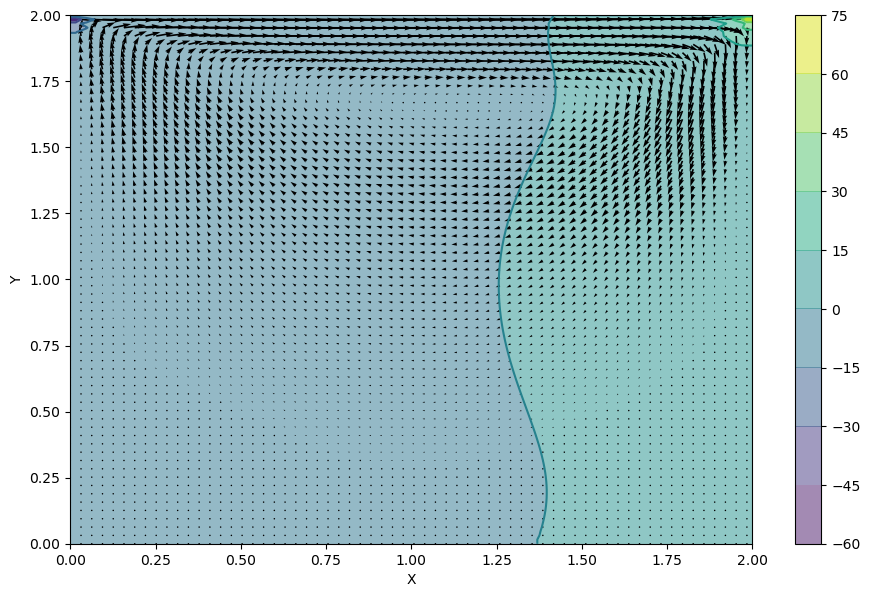

In [43]:
v = hr[0]
u = hr[1]
p = hr[2]

fig = plt.figure(figsize=(11,7), dpi=100)
# plotting the pressure field as a contour
plt.contourf(X, Y, p, alpha=0.5, cmap=cm.viridis)  
plt.colorbar()
# plotting the pressure field outlines
plt.contour(X, Y, p, cmap=cm.viridis)  
# plotting velocity field
plt.quiver(X[::2, ::2], Y[::2, ::2], u[::2, ::2], v[::2, ::2]) 
plt.xlabel('X')
plt.ylabel('Y');

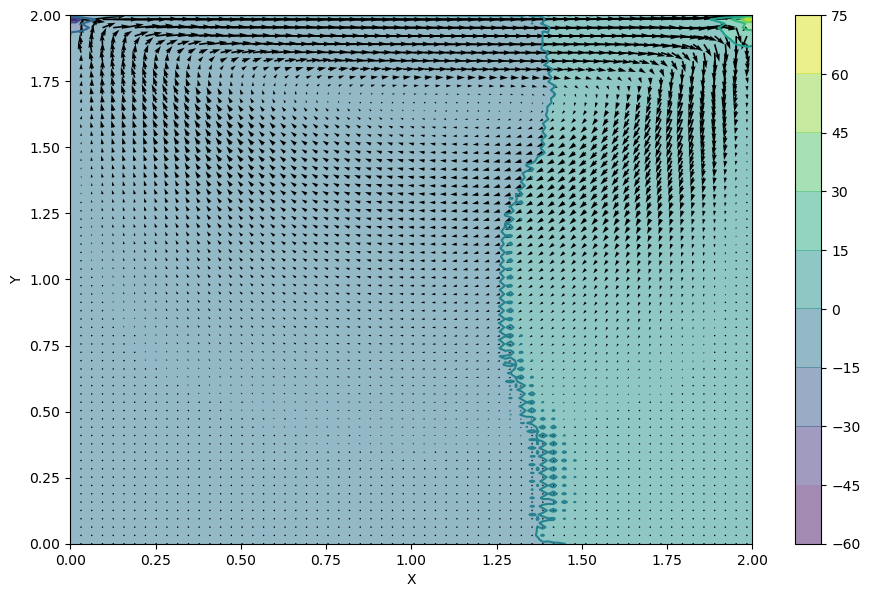

In [44]:
v = sr[0]
u = sr[1]
p = sr[2]

fig = plt.figure(figsize=(11,7), dpi=100)
# plotting the pressure field as a contour
plt.contourf(X, Y, p, alpha=0.5, cmap=cm.viridis)  
plt.colorbar()
# plotting the pressure field outlines
plt.contour(X, Y, p, cmap=cm.viridis)  
# plotting velocity field
plt.quiver(X[::2, ::2], Y[::2, ::2], u[::2, ::2], v[::2, ::2]) 
plt.xlabel('X')
plt.ylabel('Y');

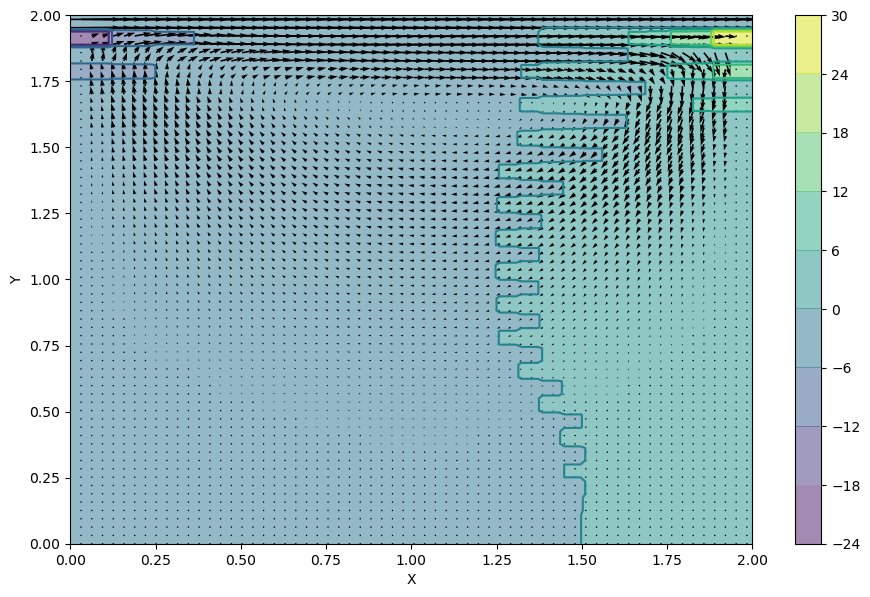

In [45]:
v = lr[0]
u = lr[1]
p = lr[2]

fig = plt.figure(figsize=(11,7), dpi=100)
# plotting the pressure field as a contour
plt.contourf(X, Y, p, alpha=0.5, cmap=cm.viridis)  
plt.colorbar()
# plotting the pressure field outlines
plt.contour(X, Y, p, cmap=cm.viridis)  
# plotting velocity field
plt.quiver(X[::2, ::2], Y[::2, ::2], u[::2, ::2], v[::2, ::2]) 
plt.xlabel('X')
plt.ylabel('Y');